In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from layer import DynamicLayerConfig, DynamicLayer
from torch import sigmoid
from tqdm import tqdm

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [2]:
from datasets import load_dataset, concatenate_datasets

dataset = load_dataset('imdb')

Found cached dataset imdb (C:/Users/javid/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

In [4]:
data = concatenate_datasets([dataset['train'], dataset['test']]).train_test_split(test_size=0.2, shuffle=True)

In [5]:
class SentimentDataset(Dataset):
    def __init__(self, dataset, tokenizer):
        self.dataset = dataset
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        text = item['text']
        label = item['label']

        encoding = self.tokenizer(text, truncation=True, return_tensors='pt')

        input_ids = encoding['input_ids'].squeeze()

        return (
            input_ids,
            label
        )

In [6]:
train_dataset = SentimentDataset(data['train'], tokenizer)
test_dataset = SentimentDataset(data['test'], tokenizer)

In [7]:
def pad_collate(batch):
  (xx, yy) = zip(*batch)
  x_lens = torch.tensor([len(x) for x in xx])
  yy = torch.tensor(yy, dtype=torch.float)

  xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)

  return xx_pad, x_lens, yy

In [8]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, collate_fn=pad_collate)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True, collate_fn=pad_collate)

In [9]:
class Model(nn.Module):
    def __init__(self, config: DynamicLayerConfig):
        super().__init__()
        self.proj_size = config.proj_size if config.proj_size != 0 else config.embed_size
        if config.bidirectional:
            self.proj_size *= 2
        self.dynamic_layer = DynamicLayer(config)
        self.fc = nn.Linear(self.proj_size, 1)
    
    def forward(
        self,
        input_ids: torch.LongTensor,
        input_lens: torch.LongTensor,
    ) -> torch.FloatTensor:

        fixed_sized = self.dynamic_layer(input_ids, input_lens)
        return sigmoid(self.fc(fixed_sized))

In [10]:
config = DynamicLayerConfig(
    vocab_size=tokenizer.vocab_size,
    embed_size=256,
    hidden_size=128,
    num_layers=2,
    bidirectional=True,
)

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
model = Model(config)
model.to(device)

Model(
  (dynamic_layer): DynamicLayer(
    (wte): Embedding(28996, 256)
    (lstm): LSTM(256, 128, num_layers=2, batch_first=True, bidirectional=True)
    (attention): DynamicLayerAttentionBlock(
      (W_Q): Linear(in_features=256, out_features=512, bias=False)
      (W_K): Linear(in_features=256, out_features=512, bias=False)
      (W_V): Linear(in_features=256, out_features=512, bias=False)
    )
  )
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

In [13]:
criterion = nn.BCELoss()

learning_rate = 3e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)


train_losses = []
val_losses = []

num_epochs = 5
for epoch in range(num_epochs):
    train_epoch_losses = []
    prediction = []
    label = []
    for x, x_lens, y in tqdm(train_loader):
        x = x.to(device)
        y = y.to(device)

        label.extend(y.detach().cpu().tolist())
        
        pred = model(x, x_lens).flatten()
        loss = criterion(pred, y)

        prediction.extend(pred.detach().cpu().tolist())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_epoch_losses.append(loss.item())
    lr_scheduler.step()
    
    label = torch.tensor(label)
    prediction = (torch.tensor(prediction) > 0.5).type(torch.FloatTensor)
    accuracy = accuracy_score(label, prediction)
    f1 = f1_score(label, prediction)
    precision = precision_score(label, prediction)
    recall = recall_score(label, prediction)

    train_losses.append(sum(train_epoch_losses) / len(train_epoch_losses))

    print(f"Train Epoch [{epoch+1}/{num_epochs}] Loss: {train_losses[-1]} Accuracy: {accuracy} F1: {f1} Precision: {precision} Recall: {recall}")

    prediction = []
    label = []
    val_epoch_losses = []
    for x, x_lens, y in tqdm(test_loader):
        x = x.to(device)
        y = y.to(device)

        label.extend(y.detach().cpu().tolist())
        
        pred = model(x, x_lens).flatten()
        loss = criterion(pred, y)

        prediction.extend(pred.detach().cpu().tolist())

        val_epoch_losses.append(loss.item())
    
    label = torch.tensor(label)
    prediction = (torch.tensor(prediction) > 0.5).type(torch.FloatTensor)
    accuracy = accuracy_score(label, prediction)
    f1 = f1_score(label, prediction)
    precision = precision_score(label, prediction)
    recall = recall_score(label, prediction)
    
    val_losses.append(sum(val_epoch_losses) / len(val_epoch_losses))
    print(f"Val Epoch [{epoch+1}/{num_epochs}] Loss: {val_losses[-1]} Accuracy: {accuracy} F1: {f1} Precision: {precision} Recall: {recall}")

100%|██████████| 625/625 [03:05<00:00,  3.37it/s]


Train Epoch [1/5] Loss: 0.5257409725666046 Accuracy: 0.761375 F1: 0.7610225081995945 Precision: 0.7618045112781955 Recall: 0.7602421089490271


100%|██████████| 157/157 [00:20<00:00,  7.50it/s]


Val Epoch [1/5] Loss: 0.37193272305521996 Accuracy: 0.8468 F1: 0.8491532099251673 Precision: 0.8377695745094229 Recall: 0.8608504691555201


100%|██████████| 625/625 [02:27<00:00,  4.24it/s]


Train Epoch [2/5] Loss: 0.32617761776447296 Accuracy: 0.868225 F1: 0.8687859401060466 Precision: 0.8647175421209118 Recall: 0.8728928017607923


100%|██████████| 157/157 [00:15<00:00,  9.91it/s]


Val Epoch [2/5] Loss: 0.30998292005365824 Accuracy: 0.8774 F1: 0.8779370768618081 Precision: 0.8756703078450844 Recall: 0.8802156118985826


100%|██████████| 625/625 [02:12<00:00,  4.72it/s]


Train Epoch [3/5] Loss: 0.253584934937954 Accuracy: 0.899825 F1: 0.9003060234369169 Precision: 0.8956043956043956 Recall: 0.9050572757740983


100%|██████████| 157/157 [00:15<00:00, 10.02it/s]


Val Epoch [3/5] Loss: 0.3195134066757123 Accuracy: 0.8791 F1: 0.8734163961888807 Precision: 0.9183179216204316 Recall: 0.832701137951687


100%|██████████| 625/625 [02:10<00:00,  4.77it/s]


Train Epoch [4/5] Loss: 0.20233774168491364 Accuracy: 0.921275 F1: 0.9215476220135032 Precision: 0.9179571173317451 Recall: 0.9251663248461808


100%|██████████| 157/157 [00:14<00:00, 10.65it/s]


Val Epoch [4/5] Loss: 0.30262065560195095 Accuracy: 0.8858 F1: 0.8812148949448722 Precision: 0.9198697068403909 Recall: 0.8456777799960072


100%|██████████| 625/625 [02:09<00:00,  4.81it/s]


Train Epoch [5/5] Loss: 0.1562177701026201 Accuracy: 0.942075 F1: 0.9422410569612364 Precision: 0.9391274100576427 Recall: 0.9453754189385223


100%|██████████| 157/157 [00:15<00:00, 10.24it/s]

Val Epoch [5/5] Loss: 0.2969469239187848 Accuracy: 0.8923 F1: 0.8891861302603149 Precision: 0.9174097664543525 Recall: 0.8626472349770413


In [14]:
torch.save(model, 'model.pt')

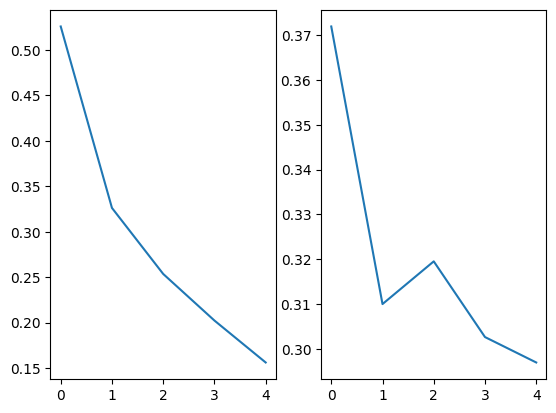

In [15]:
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.subplot(1, 2, 2)
plt.plot(val_losses)